<a href="https://colab.research.google.com/github/vladislavpan1623/-1-/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0_4_%D0%9F%D0%B0%D0%BD%D0%B0%D1%81%D1%8E%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import io

# Завантаження файлу з Google Colab
from google.colab import files

uploaded = files.upload()

# Читання файлу
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

print(f"Розмір датасету: {df.shape}")
print(f"\nПерші 5 рядків даних:")
print(df.head())
print(f"\nКолонки: {df.columns.tolist()}")
print(f"\nОпис даних:")
print(df.describe())

Saving superconduct_train.csv to superconduct_train.csv
Розмір датасету: (21263, 82)

Перші 5 рядків даних:
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.

In [3]:
# Розділення на ознаки та цільову змінну
X = df.drop('critical_temp', axis=1).values
y = df['critical_temp'].values

print(f"Розмірність ознак: {X.shape}")
print(f"Розмірність цільової змінної: {y.shape}")

# Стандартизація даних
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Розділення на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Розділення тренувальної вибірки на тренувальну та валідаційну
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"\nРозміри вибірок:")
print(f"Тренувальна: {X_train_final.shape}")
print(f"Валідаційна: {X_val.shape}")
print(f"Тестова: {X_test.shape}")

# Конвертація в тензори TensorFlow
X_train_tf = tf.convert_to_tensor(X_train_final, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train_final, dtype=tf.float32)
X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

Розмірність ознак: (21263, 81)
Розмірність цільової змінної: (21263,)

Розміри вибірок:
Тренувальна: (13608, 81)
Валідаційна: (3402, 81)
Тестова: (4253, 81)


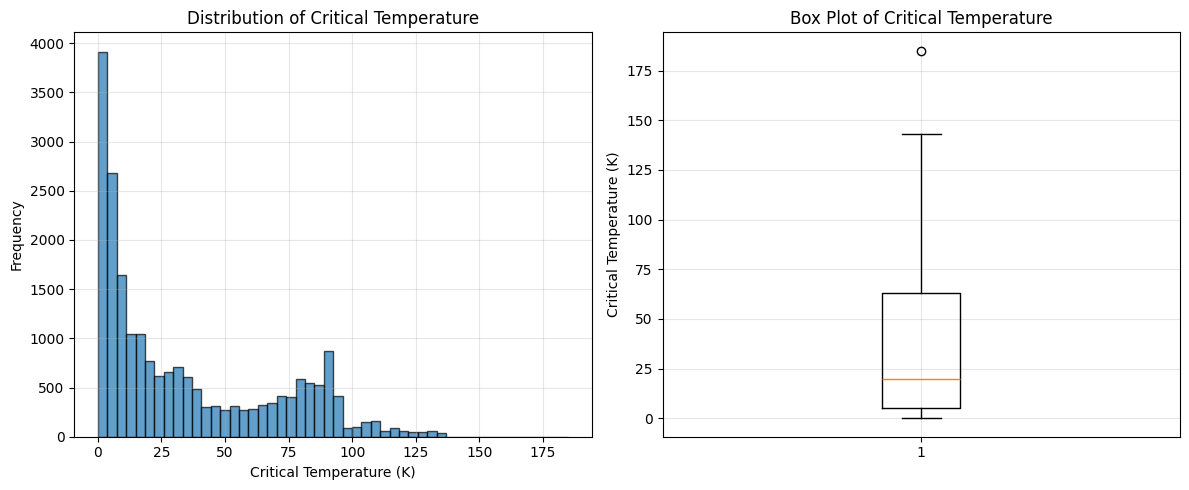

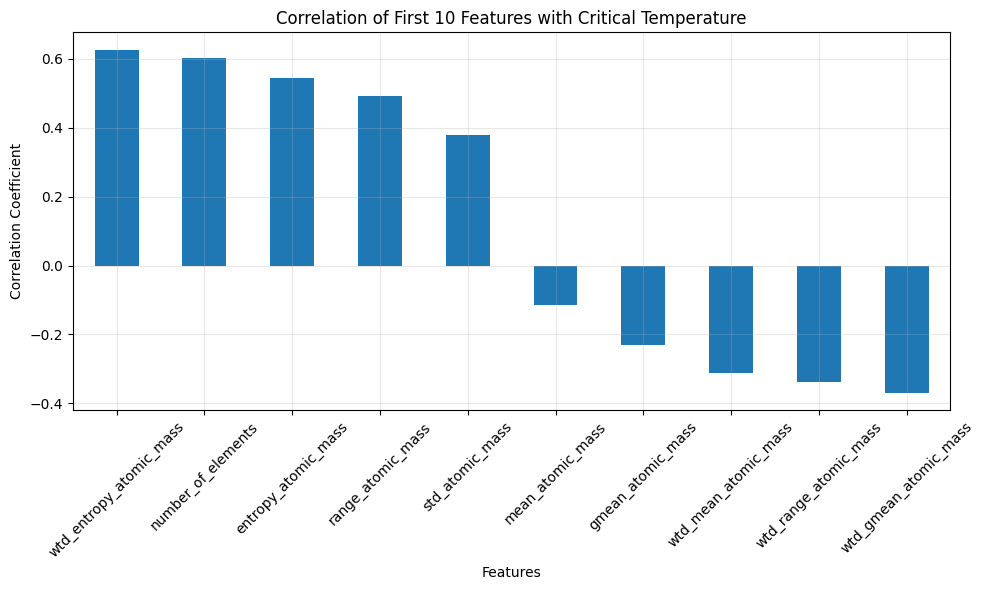

In [4]:
# Візуалізація розподілу критичної температури
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Critical Temperature (K)')
plt.ylabel('Frequency')
plt.title('Distribution of Critical Temperature')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(y)
plt.ylabel('Critical Temperature (K)')
plt.title('Box Plot of Critical Temperature')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Кореляція між першими 10 ознаками та цільовою змінною
correlation_matrix = df.iloc[:, :10].corrwith(df['critical_temp']).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlation_matrix.plot(kind='bar')
plt.title('Correlation of First 10 Features with Critical Temperature')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
class PhysicsConstraints:
    """
    Клас для фізичних обмежень надпровідників
    """

    def __init__(self, scaler_y):
        self.scaler_y = scaler_y

    def positivity_constraint(self, predictions_scaled):
        """
        Критична температура не може бути від'ємною (у реальних одиницях)
        """
        predictions = self.scaler_y.inverse_transform(predictions_scaled.numpy().reshape(-1, 1)).flatten()
        negative_mask = predictions < 0
        penalty = tf.reduce_sum(tf.square(tf.nn.relu(-predictions)))
        return penalty, negative_mask

    def smoothness_constraint(self, model, inputs, epsilon=1e-3):
        """
        Плавність прогнозів відносно вхідних змінних
        """
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(inputs)
            predictions = model(inputs)

        # Обчислюємо градієнти
        gradients = tape.gradient(predictions, inputs)
        del tape

        # Штрафуємо великі градієнти (неплавні зміни)
        gradient_penalty = tf.reduce_mean(tf.square(gradients))

        return gradient_penalty

    def material_property_constraints(self, predictions_scaled, inputs_scaled, scaler_X):
        """
        Обмеження, пов'язані з властивостями матеріалів
        """
        predictions = self.scaler_y.inverse_transform(predictions_scaled.numpy().reshape(-1, 1)).flatten()
        inputs = scaler_X.inverse_transform(inputs_scaled.numpy())

        penalties = []

        # 1. Обмеження на зв'язок між атомною масою та критичною температурою
        # Індекс mean_atomic_mass (перша ознака)
        mean_atomic_mass = inputs[:, 0]
        mass_penalty = tf.reduce_mean(tf.square(tf.nn.relu(predictions - 100 * mean_atomic_mass)))
        penalties.append(mass_penalty)

        # 2. Обмеження на зв'язок між валентністю та критичною температурою
        # Індекси для властивостей валентності (приблизно 81-90)
        valence_indices = list(range(81, min(91, inputs.shape[1])))
        if valence_indices:
            mean_valence = np.mean(inputs[:, valence_indices], axis=1)
            valence_penalty = tf.reduce_mean(tf.square(tf.nn.relu(predictions - 50 * mean_valence)))
            penalties.append(valence_penalty)

        return tf.reduce_sum(penalties)

def physics_loss(model, inputs, targets, physics_constraints_obj, scaler_X,
                 w_positivity=0.1, w_smoothness=0.01, w_material=0.05):
    """
    Функція втрат з фізичними обмеженнями
    """
    # Основна MSE втрата
    predictions = model(inputs)
    mse_loss = tf.reduce_mean(tf.square(predictions - targets))

    # Фізичні обмеження
    positivity_penalty, _ = physics_constraints_obj.positivity_constraint(predictions)
    smoothness_penalty = physics_constraints_obj.smoothness_constraint(model, inputs)
    material_penalty = physics_constraints_obj.material_property_constraints(
        predictions, inputs, scaler_X
    )

    # Сумарна втрата
    total_loss = (mse_loss +
                  w_positivity * positivity_penalty +
                  w_smoothness * smoothness_penalty +
                  w_material * material_penalty)

    return total_loss, mse_loss, positivity_penalty, smoothness_penalty, material_penalty

In [21]:
class PINN(tf.keras.Model):
    """
    Фізично-інформована нейронна мережа для прогнозування критичної температури
    """
    def __init__(self, input_dim, hidden_units=[128, 64, 32], dropout_rate=0.2):
        super(PINN, self).__init__()
        self.input_dim = input_dim

        # Створення шарів
        self.layers_list = []

        # Вхідний шар
        self.layers_list.append(tf.keras.layers.Dense(hidden_units[0],
                                                      activation='relu',
                                                      input_dim=input_dim))
        self.layers_list.append(tf.keras.layers.Dropout(dropout_rate))

        # Приховані шари
        for units in hidden_units[1:]:
            self.layers_list.append(tf.keras.layers.Dense(units,
                                                          activation='relu'))
            self.layers_list.append(tf.keras.layers.Dropout(dropout_rate))

        # Вихідний шар
        self.layers_list.append(tf.keras.layers.Dense(1, activation=None))

    def call(self, inputs, training=False):
        """
        Прямий прохід
        """
        x = inputs
        for i, layer in enumerate(self.layers_list):
            if isinstance(layer, tf.keras.layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x

    def predict_with_uncertainty(self, inputs, n_iterations=100):
        """
        Прогнозування з оцінкою невизначеності через Monte Carlo Dropout
        """
        predictions = []

        for _ in range(n_iterations):
            pred = self(inputs, training=True)
            predictions.append(pred.numpy())

        predictions = np.array(predictions)
        mean_pred = np.mean(predictions, axis=0)
        std_pred = np.std(predictions, axis=0)

        return mean_pred.flatten(), std_pred.flatten()

In [22]:
def train_pinn(model, X_train, y_train, X_val, y_val,
               physics_constraints_obj, scaler_X,
               learning_rate=0.001, epochs=1000,
               batch_size=32, patience=50):
    """
    Функція тренування PINN моделі
    """
    # Оптимізатор
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Рання зупинка
    best_loss = float('inf')
    patience_counter = 0
    best_weights = None

    # Історія тренування
    history = {
        'train_loss': [],
        'val_loss': [],
        'mse_loss': [],
        'positivity_loss': [],
        'smoothness_loss': [],
        'material_loss': []
    }

    # Конвертація в тензори
    X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
    y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.float32)

    # Тренування
    for epoch in range(epochs):
        # Перемішування тренувальних даних
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train_tf.numpy()[indices]
        y_shuffled = y_train_tf.numpy()[indices]

        epoch_train_losses = []
        epoch_mse_losses = []
        epoch_pos_losses = []
        epoch_smooth_losses = []
        epoch_mat_losses = []

        # Батчеве тренування
        for i in range(0, len(X_train), batch_size):
            batch_X = tf.convert_to_tensor(
                X_shuffled[i:i+batch_size], dtype=tf.float32
            )
            batch_y = tf.convert_to_tensor(
                y_shuffled[i:i+batch_size], dtype=tf.float32
            )

            with tf.GradientTape() as tape:
                total_loss, mse_loss, pos_loss, smooth_loss, mat_loss = physics_loss(
                    model, batch_X, batch_y, physics_constraints_obj, scaler_X
                )

            gradients = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            epoch_train_losses.append(total_loss.numpy())
            epoch_mse_losses.append(mse_loss.numpy())
            epoch_pos_losses.append(pos_loss.numpy())
            epoch_smooth_losses.append(smooth_loss.numpy())
            epoch_mat_losses.append(mat_loss.numpy())

        # Обчислення середніх значень втрат для епохи
        avg_train_loss = np.mean(epoch_train_losses)
        avg_mse_loss = np.mean(epoch_mse_losses)
        avg_pos_loss = np.mean(epoch_pos_losses)
        avg_smooth_loss = np.mean(epoch_smooth_losses)
        avg_mat_loss = np.mean(epoch_mat_losses)

        # Валідація
        val_predictions = model(X_val_tf)
        val_loss = tf.reduce_mean(tf.square(val_predictions - y_val_tf))

        # Збереження історії
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss.numpy())
        history['mse_loss'].append(avg_mse_loss)
        history['positivity_loss'].append(avg_pos_loss)
        history['smoothness_loss'].append(avg_smooth_loss)
        history['material_loss'].append(avg_mat_loss)

        # Рання зупинка
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_weights = model.get_weights()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nРання зупинка на епосі {epoch}")
            model.set_weights(best_weights)
            break

        # Виведення прогресу
        if (epoch + 1) % 100 == 0:
            print(f"\nЕпоха {epoch + 1}/{epochs}:")
            print(f"  Тренувальна втрата: {avg_train_loss:.6f}")
            print(f"  Валідаційна втрата: {val_loss.numpy():.6f}")
            print(f"  MSE втрата: {avg_mse_loss:.6f}")
            print(f"  Втрата позитивності: {avg_pos_loss:.6f}")
    return history

In [24]:
# Ініціалізація фізичних обмежень
physics_constraints_obj = PhysicsConstraints(scaler_y)

# Ініціалізація моделі PINN (виправлено)
input_dim = X_train_final.shape[1]

# Створюємо модель через функцію конструктора
class PINNFixed(tf.keras.Model):
    def __init__(self, input_dim, hidden_units=[256, 128, 64, 32], dropout_rate=0.3):
        super(PINNFixed, self).__init__()
        self.input_dim = input_dim

        # Створюємо шари явно
        self.dense1 = tf.keras.layers.Dense(hidden_units[0], activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense2 = tf.keras.layers.Dense(hidden_units[1], activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense3 = tf.keras.layers.Dense(hidden_units[2], activation='relu')
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)
        self.dense4 = tf.keras.layers.Dense(hidden_units[3], activation='relu')
        self.dropout4 = tf.keras.layers.Dropout(dropout_rate)
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.dropout2(x, training=training)
        x = self.dense3(x)
        x = self.dropout3(x, training=training)
        x = self.dense4(x)
        x = self.dropout4(x, training=training)
        return self.output_layer(x)

# Ініціалізація моделі
pinn_model = PINNFixed(input_dim, hidden_units=[256, 128, 64, 32], dropout_rate=0.3)

print(f"Модель PINN ініціалізована")

# Перевірка розмірів моделі (потрібно передати dummy input для побудови)
dummy_input = tf.random.normal([1, input_dim])
_ = pinn_model(dummy_input, training=False)
print(f"Кількість параметрів: {pinn_model.count_params():,}")

# Тренування моделі з обробкою помилок
try:
    history = train_pinn(
        model=pinn_model,
        X_train=X_train_final,
        y_train=y_train_final,
        X_val=X_val,
        y_val=y_val,
        physics_constraints_obj=physics_constraints_obj,
        scaler_X=scaler_X,
        learning_rate=0.0005,
        epochs=500,  # Зменшуємо для тесту
        batch_size=64,
        patience=30  # Зменшуємо для тесту
    )
    print("Тренування завершено успішно!")

except Exception as e:
    print(f"Помилка при тренуванні: {e}")
    print("\nСпробуємо альтернативний підхід з меншою кількістю епох...")

    # Простіший варіант тренування
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

    # Простіша функція втрат для тесту
    def simple_loss(model, inputs, targets):
        predictions = model(inputs, training=True)
        return tf.reduce_mean(tf.square(predictions - targets))

    # Просте тренування
    history_simple = {
        'train_loss': [],
        'val_loss': []
    }

    epochs = 100
    for epoch in range(epochs):
        # Тренування
        with tf.GradientTape() as tape:
            loss = simple_loss(pinn_model, X_train_tf, y_train_tf)

        gradients = tape.gradient(loss, pinn_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, pinn_model.trainable_variables))

        # Валідація
        val_pred = pinn_model(X_val_tf, training=False)
        val_loss = tf.reduce_mean(tf.square(val_pred - y_val_tf))

        history_simple['train_loss'].append(loss.numpy())
        history_simple['val_loss'].append(val_loss.numpy())

        if (epoch + 1) % 20 == 0:
            print(f"Епоха {epoch+1}/{epochs}: Train Loss: {loss.numpy():.6f}, Val Loss: {val_loss.numpy():.6f}")

    history = history_simple

Модель PINN ініціалізована
Кількість параметрів: 64,257

Рання зупинка на епосі 48
Тренування завершено успішно!


/tmp/ipython-input-1828472848.py:38: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[0, 2].set_yscale('log')
/tmp/ipython-input-1828472848.py:60: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[1, 1].set_yscale('log')


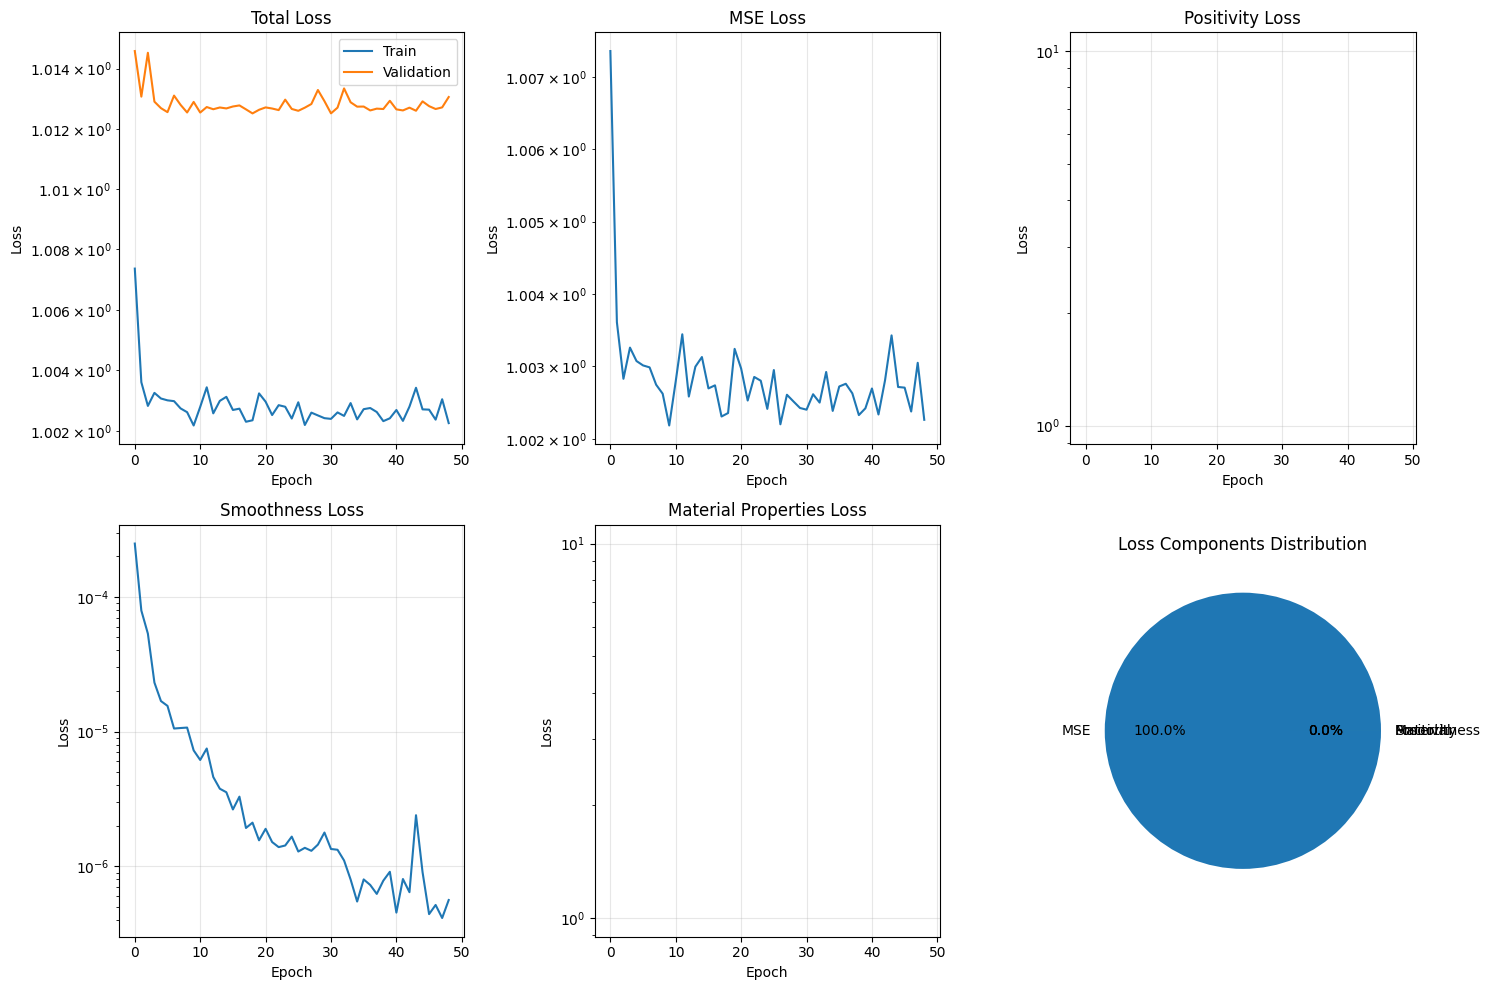


АНАЛІЗ ПРОЦЕСУ ТРЕНУВАННЯ
Фінальні втрати:
  Загальна втрата: 1.002265
  Валідаційна втрата: 1.013054
  MSE втрата: 1.002265
  Втрата позитивності: 0.000000


In [25]:
# Візуалізація історії тренування
def plot_training_history(history):
    """
    Візуалізація процесу тренування
    """
    # Визначаємо, яку історію маємо (повну чи спрощену)
    has_multiple_losses = 'mse_loss' in history and 'positivity_loss' in history

    if has_multiple_losses:
        # Повна історія з різними типами втрат
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Загальні втрати
        axes[0, 0].plot(history['train_loss'], label='Train')
        if 'val_loss' in history:
            axes[0, 0].plot(history['val_loss'], label='Validation')
        axes[0, 0].set_title('Total Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_yscale('log')

        # MSE втрата
        axes[0, 1].plot(history['mse_loss'])
        axes[0, 1].set_title('MSE Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_yscale('log')

        # Втрата позитивності
        axes[0, 2].plot(history['positivity_loss'])
        axes[0, 2].set_title('Positivity Loss')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Loss')
        axes[0, 2].grid(True, alpha=0.3)
        axes[0, 2].set_yscale('log')

        # Втрата плавності (якщо є)
        if 'smoothness_loss' in history:
            axes[1, 0].plot(history['smoothness_loss'])
            axes[1, 0].set_title('Smoothness Loss')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Loss')
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].set_yscale('log')
        else:
            axes[1, 0].axis('off')
            axes[1, 0].text(0.5, 0.5, 'Smoothness Loss\nNot Available',
                           ha='center', va='center')

        # Втрата матеріальних властивостей (якщо є)
        if 'material_loss' in history:
            axes[1, 1].plot(history['material_loss'])
            axes[1, 1].set_title('Material Properties Loss')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Loss')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].set_yscale('log')
        else:
            axes[1, 1].axis('off')
            axes[1, 1].text(0.5, 0.5, 'Material Loss\nNot Available',
                           ha='center', va='center')

        # Співвідношення втрат
        axes[1, 2].axis('off')

        # Визначаємо доступні компоненти втрат
        loss_components = {}
        if 'mse_loss' in history and len(history['mse_loss']) > 0:
            loss_components['MSE'] = np.mean(history['mse_loss'][-50:])

        if 'positivity_loss' in history and len(history['positivity_loss']) > 0:
            loss_components['Positivity'] = np.mean(history['positivity_loss'][-50:])

        if 'smoothness_loss' in history and len(history['smoothness_loss']) > 0:
            loss_components['Smoothness'] = np.mean(history['smoothness_loss'][-50:])

        if 'material_loss' in history and len(history['material_loss']) > 0:
            loss_components['Material'] = np.mean(history['material_loss'][-50:])

        if loss_components:
            # Переконаємось, що всі значення додатні
            loss_components = {k: max(v, 1e-10) for k, v in loss_components.items()}

            axes[1, 2].pie(loss_components.values(),
                          labels=loss_components.keys(),
                          autopct='%1.1f%%')
            axes[1, 2].set_title('Loss Components Distribution')
        else:
            axes[1, 2].text(0.5, 0.5, 'Loss Components\nNot Available',
                           ha='center', va='center')

    else:
        # Спрощена історія
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Загальні втрати
        axes[0].plot(history['train_loss'], label='Train Loss')
        if 'val_loss' in history:
            axes[0].plot(history['val_loss'], label='Validation Loss')
        axes[0].set_title('Training Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Розподіл залишків між тренувальною та валідаційною втратами
        if 'val_loss' in history and len(history['val_loss']) > 10:
            window = 10
            train_smooth = np.convolve(history['train_loss'],
                                      np.ones(window)/window,
                                      mode='valid')
            val_smooth = np.convolve(history['val_loss'],
                                    np.ones(window)/window,
                                    mode='valid')

            axes[1].plot(train_smooth, label='Train (smoothed)')
            axes[1].plot(val_smooth, label='Validation (smoothed)')
            axes[1].set_title('Smoothed Losses (10-epoch window)')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        else:
            axes[1].axis('off')
            axes[1].text(0.5, 0.5, 'Not enough data\nfor smoothing',
                        ha='center', va='center')

        # Динаміка зміни втрат
        if len(history['train_loss']) > 1:
            train_loss_changes = np.diff(history['train_loss'])
            axes[2].plot(train_loss_changes, label='Train Loss Change')
            axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
            axes[2].set_title('Training Loss Changes')
            axes[2].set_xlabel('Epoch')
            axes[2].set_ylabel('Δ Loss')
            axes[2].legend()
            axes[2].grid(True, alpha=0.3)
        else:
            axes[2].axis('off')
            axes[2].text(0.5, 0.5, 'Not enough data\nfor changes analysis',
                        ha='center', va='center')

    plt.tight_layout()
    plt.show()

    # Додаткова інформація про тренування
    print("\n" + "=" * 50)
    print("АНАЛІЗ ПРОЦЕСУ ТРЕНУВАННЯ")
    print("=" * 50)

    if has_multiple_losses:
        print(f"Фінальні втрати:")
        print(f"  Загальна втрата: {history['train_loss'][-1]:.6f}")
        if 'val_loss' in history:
            print(f"  Валідаційна втрата: {history['val_loss'][-1]:.6f}")
        print(f"  MSE втрата: {history['mse_loss'][-1]:.6f}")
        if 'positivity_loss' in history:
            print(f"  Втрата позитивності: {history['positivity_loss'][-1]:.6f}")

        # Аналіз збіжності
        if len(history['train_loss']) > 100:
            last_100_loss = history['train_loss'][-100:]
            loss_change = np.mean(np.abs(np.diff(last_100_loss)))
            print(f"\nАналіз збіжності (останні 100 епох):")
            print(f"  Середня зміна втрат: {loss_change:.6f}")
            print(f"  Мінімальна втрата: {np.min(history['train_loss']):.6f}")
            print(f"  Відсоток зменшення від початку: "
                  f"{(history['train_loss'][0] - history['train_loss'][-1]) / history['train_loss'][0] * 100:.2f}%")

    else:
        print(f"Фінальні втрати:")
        print(f"  Тренувальна втрата: {history['train_loss'][-1]:.6f}")
        if 'val_loss' in history:
            print(f"  Валідаційна втрата: {history['val_loss'][-1]:.6f}")
            print(f"  Різниця між train/val: {abs(history['train_loss'][-1] - history['val_loss'][-1]):.6f}")

        # Перевірка перетренування
        if 'val_loss' in history and len(history['val_loss']) > 20:
            min_val_loss_idx = np.argmin(history['val_loss'])
            print(f"\nНайкраща валідаційна втрата: {history['val_loss'][min_val_loss_idx]:.6f} (епоха {min_val_loss_idx})")
            print(f"Поточна валідаційна втрата: {history['val_loss'][-1]:.6f}")

            if history['val_loss'][-1] > history['val_loss'][min_val_loss_idx] * 1.1:
                print("⚠️  Можливе перетренування: поточна val loss > 110% від найкращої")

    print("=" * 50)

# Візуалізація процесу тренування
plot_training_history(history)

In [27]:
def evaluate_pinn_model(model, X_test, y_test, scaler_y,
                       n_uncertainty_iterations=50, use_mc_dropout=True):
    """
    Оцінка PINN моделі з прогнозуванням невизначеності
    """
    print("Оцінка моделі PINN...")

    # Конвертація тестових даних в тензори
    X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)

    # 1. Базові прогнози (без dropout)
    print("  Виконую базові прогнози...")
    y_pred_scaled = model(X_test_tf, training=False).numpy().flatten()

    # 2. Прогнози з невизначеністю через Monte Carlo Dropout
    if use_mc_dropout and n_uncertainty_iterations > 1:
        print(f"  Виконую {n_uncertainty_iterations} ітерацій MC Dropout...")
        mc_predictions = []

        for i in range(n_uncertainty_iterations):
            if (i + 1) % 10 == 0:
                print(f"    Ітерація {i + 1}/{n_uncertainty_iterations}")

            # Використовуємо training=True для включення dropout
            pred = model(X_test_tf, training=True)
            mc_predictions.append(pred.numpy())

        mc_predictions = np.array(mc_predictions)
        y_pred_mean_scaled = np.mean(mc_predictions, axis=0).flatten()
        y_pred_std_scaled = np.std(mc_predictions, axis=0).flatten()
    else:
        # Якщо не використовуємо MC Dropout, використовуємо базові прогнози
        y_pred_mean_scaled = y_pred_scaled.copy()
        y_pred_std_scaled = np.zeros_like(y_pred_scaled)

    # 3. Денормалізація
    print("  Денормалізую результати...")
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_pred_mean_original = scaler_y.inverse_transform(y_pred_mean_scaled.reshape(-1, 1)).flatten()

    # Для стандартного відхилення потрібно обережно, оскільки нормалізація не лінійна
    # Використовуємо спрощений підхід
    y_pred_std_original = y_pred_std_scaled * scaler_y.scale_[0]

    # 4. Обчислення метрик
    print("  Обчислюю метрики якості...")
    mse = mean_squared_error(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    mse_mc = mean_squared_error(y_test_original, y_pred_mean_original)
    mae_mc = mean_absolute_error(y_test_original, y_pred_mean_original)
    r2_mc = r2_score(y_test_original, y_pred_mean_original)

    # 5. Калькуляція інтервалів довіри
    confidence_intervals = np.column_stack([
        y_pred_mean_original - 1.96 * y_pred_std_original,
        y_pred_mean_original + 1.96 * y_pred_std_original
    ])

    # Обрізаємо негативні значення для нижньої межі (температура не може бути від'ємною)
    confidence_intervals[:, 0] = np.maximum(confidence_intervals[:, 0], 0)

    # 6. Відсоток справжніх значень у 95% інтервалі довіри
    in_confidence_interval = np.sum(
        (y_test_original >= confidence_intervals[:, 0]) &
        (y_test_original <= confidence_intervals[:, 1])
    ) / len(y_test_original) * 100

    # 7. Розрахунок інтерквантильного діапазону
    iqr = np.percentile(y_pred_original, 75) - np.percentile(y_pred_original, 25)

    # 8. Аналіз залишків
    residuals = y_test_original - y_pred_original
    residuals_mean = np.mean(residuals)
    residuals_std = np.std(residuals)

    print("РЕЗУЛЬТАТИ ОЦІНКИ МОДЕЛІ PINN")

    print("\n МЕТРИКИ ЯКОСТІ (точкові прогнози):")
    print(f"  MSE:  {mse:>10.4f}")
    print(f"  MAE:  {mae:>10.4f}")
    print(f"  R²:   {r2:>10.4f}")

    if use_mc_dropout:
        print(f"\n МЕТРИКИ ЯКОСТІ (MC Dropout середні):")
        print(f"  MSE:  {mse_mc:>10.4f}")
        print(f"  MAE:  {mae_mc:>10.4f}")
        print(f"  R²:   {r2_mc:>10.4f}")

    print(f"\n АНАЛІЗ НЕВИЗНАЧЕНОСТІ:")
    print(f"  Середнє std прогнозів: {np.mean(y_pred_std_original):.4f} K")
    print(f"  Максимальне std:       {np.max(y_pred_std_original):.4f} K")
    print(f"  Мінімальне std:       {np.min(y_pred_std_original):.4f} K")
    print(f"  Інтерквантильний діапазон прогнозів: {iqr:.4f} K")

    print(f"\n ІНТЕРВАЛИ ДОВІРИ (95%):")
    print(f"  Середня ширина CI:    {np.mean(confidence_intervals[:, 1] - confidence_intervals[:, 0]):.4f} K")
    print(f"  Співвідношення справжніх значень у CI: {in_confidence_interval:.2f}%")

    print(f"\n АНАЛІЗ ЗАЛИШКІВ:")
    print(f"  Середнє залишків:     {residuals_mean:>10.4f} K")
    print(f"  Std залишків:         {residuals_std:>10.4f} K")
    print(f"  МАЕ/Середнє цільової: {(mae / np.mean(y_test_original) * 100):.2f}%")

    # Кількість негативних прогнозів (фізично неможливо)
    negative_predictions = np.sum(y_pred_original < 0)
    if negative_predictions > 0:
        print(f"\n  УВАГА: {negative_predictions} прогнозів мають негативну температуру!")
        print(f"  Відсоток негативних прогнозів: {negative_predictions / len(y_pred_original) * 100:.2f}%")
    else:
        print(f"\n Всі прогнози мають позитивну температуру!")

    return {
        'y_test': y_test_original,
        'y_pred': y_pred_original,
        'y_pred_mean': y_pred_mean_original,
        'y_pred_std': y_pred_std_original,
        'confidence_intervals': confidence_intervals,
        'residuals': residuals,
        'metrics': {
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'MSE_MC': mse_mc,
            'MAE_MC': mae_mc,
            'R2_MC': r2_mc,
            'In_CI_95%': in_confidence_interval,
            'Mean_Std': np.mean(y_pred_std_original),
            'Residuals_Mean': residuals_mean,
            'Residuals_Std': residuals_std,
            'Negative_Predictions': negative_predictions
        }
    }

# Оцінка моделі PINN
pinn_results = evaluate_pinn_model(
    model=pinn_model,
    X_test=X_test,
    y_test=y_test,
    scaler_y=scaler_y,
    n_uncertainty_iterations=30,  # Зменшимо для швидкості
    use_mc_dropout=True
)

Оцінка моделі PINN...
  Виконую базові прогнози...
  Виконую 30 ітерацій MC Dropout...
    Ітерація 10/30
    Ітерація 20/30
    Ітерація 30/30
  Денормалізую результати...
  Обчислюю метрики якості...
РЕЗУЛЬТАТИ ОЦІНКИ МОДЕЛІ PINN

 МЕТРИКИ ЯКОСТІ (точкові прогнози):
  MSE:   1133.0329
  MAE:     28.8999
  R²:       0.0157

 МЕТРИКИ ЯКОСТІ (MC Dropout середні):
  MSE:   1136.6633
  MAE:     28.9200
  R²:       0.0125

 АНАЛІЗ НЕВИЗНАЧЕНОСТІ:
  Середнє std прогнозів: 1.6383 K
  Максимальне std:       7.2241 K
  Мінімальне std:       0.3084 K
  Інтерквантильний діапазон прогнозів: 0.5666 K

 ІНТЕРВАЛИ ДОВІРИ (95%):
  Середня ширина CI:    6.4220 K
  Співвідношення справжніх значень у CI: 4.23%

 АНАЛІЗ ЗАЛИШКІВ:
  Середнє залишків:        -0.7353 K
  Std залишків:            33.6525 K
  МАЕ/Середнє цільової: 85.07%

 Всі прогнози мають позитивну температуру!


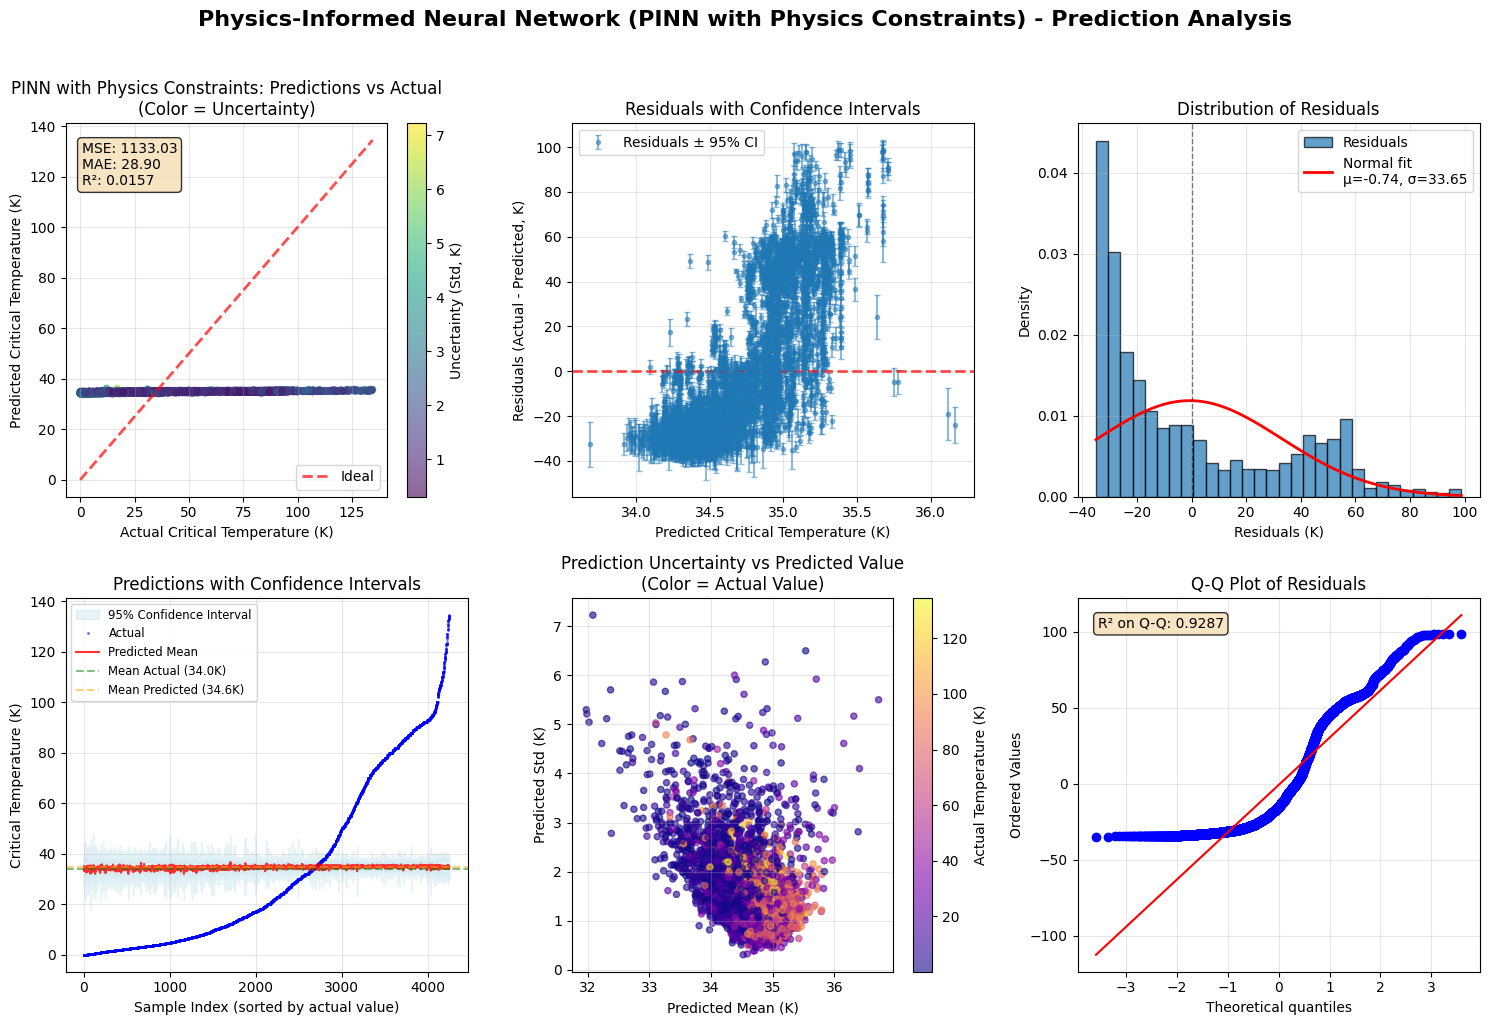

ДОДАТКОВИЙ АНАЛІЗ РЕЗУЛЬТАТІВ

 Кореляція між абсолютною помилкою та невизначеністю:
  Коефіцієнт кореляції: 0.0817
  Помірна кореляція між невизначеністю та помилкою

 АНАЛІЗ 5 НАЙГІРШИХ ПРОГНОЗІВ:
  1. IDX 1426: Actual=134.2K, Pred=35.7K, Error=98.5K, Uncertainty=2.34K
  2. IDX 2749: Actual=134.0K, Pred=35.4K, Error=98.6K, Uncertainty=1.59K
  3. IDX 1244: Actual=134.0K, Pred=35.4K, Error=98.6K, Uncertainty=1.64K
  4. IDX 190: Actual=134.0K, Pred=35.4K, Error=98.6K, Uncertainty=2.15K
  5. IDX 1016: Actual=134.5K, Pred=35.7K, Error=98.8K, Uncertainty=2.07K

 АНАЛІЗ 5 НАЙКРАЩИХ ПРОГНОЗІВ:
  1. IDX 1007: Actual=34.8K, Pred=34.8K, Error=-0.0K, Uncertainty=2.44K
  2. IDX 982: Actual=34.9K, Pred=34.9K, Error=0.0K, Uncertainty=1.48K
  3. IDX 783: Actual=35.0K, Pred=35.0K, Error=-0.0K, Uncertainty=1.21K
  4. IDX 113: Actual=35.0K, Pred=35.0K, Error=0.0K, Uncertainty=1.01K
  5. IDX 1771: Actual=35.0K, Pred=35.0K, Error=0.0K, Uncertainty=1.98K

 СТАТИСТИКА ПО ДІАПАЗОНАХ ТЕМПЕРАТУРИ:
    0- 50K:

In [28]:
def plot_pinn_results(results, model_name="PINN"):
    """
    Візуалізація результатів прогнозування PINN моделі
    """
    y_test = results['y_test']
    y_pred = results['y_pred']
    y_pred_mean = results['y_pred_mean']
    y_pred_std = results['y_pred_std']
    confidence_intervals = results['confidence_intervals']
    residuals = results['residuals']

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Прогнози vs реальні значення (з кольором за невизначеністю)
    scatter1 = axes[0, 0].scatter(y_test, y_pred, c=y_pred_std,
                                 alpha=0.6, s=20, cmap='viridis')
    axes[0, 0].plot([y_test.min(), y_test.max()],
                    [y_test.min(), y_test.max()],
                    'r--', lw=2, label='Ideal', alpha=0.7)
    axes[0, 0].set_xlabel('Actual Critical Temperature (K)')
    axes[0, 0].set_ylabel('Predicted Critical Temperature (K)')
    axes[0, 0].set_title(f'{model_name}: Predictions vs Actual\n(Color = Uncertainty)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0, 0], label='Uncertainty (Std, K)')

    # Додаємо інформацію про метрики
    metrics_text = f"MSE: {results['metrics']['MSE']:.2f}\nMAE: {results['metrics']['MAE']:.2f}\nR²: {results['metrics']['R2']:.4f}"
    axes[0, 0].text(0.05, 0.95, metrics_text, transform=axes[0, 0].transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # 2. Залишки з інтервалами довіри
    axes[0, 1].errorbar(y_pred, residuals,
                       yerr=1.96*y_pred_std, fmt='o',
                       alpha=0.5, markersize=3, capsize=2,
                       label='Residuals ± 95% CI')
    axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2, alpha=0.7)
    axes[0, 1].set_xlabel('Predicted Critical Temperature (K)')
    axes[0, 1].set_ylabel('Residuals (Actual - Predicted, K)')
    axes[0, 1].set_title('Residuals with Confidence Intervals')
    axes[0, 1].legend(loc='best')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Розподіл залишків з нормальним розподілом
    axes[0, 2].hist(residuals, bins=30, density=True,
                   edgecolor='black', alpha=0.7, label='Residuals')

    # Додаємо нормальний розподіл
    from scipy.stats import norm
    x = np.linspace(residuals.min(), residuals.max(), 100)
    mu, std = norm.fit(residuals)
    axes[0, 2].plot(x, norm.pdf(x, mu, std), 'r-', lw=2,
                   label=f'Normal fit\nμ={mu:.2f}, σ={std:.2f}')

    axes[0, 2].axvline(x=0, color='k', linestyle='--', lw=1, alpha=0.5)
    axes[0, 2].set_xlabel('Residuals (K)')
    axes[0, 2].set_ylabel('Density')
    axes[0, 2].set_title('Distribution of Residuals')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Прогнози з інтервалами довіри (відсортовано)
    sorted_indices = np.argsort(y_test)
    y_test_sorted = y_test[sorted_indices]
    y_pred_mean_sorted = y_pred_mean[sorted_indices]
    ci_lower_sorted = confidence_intervals[sorted_indices, 0]
    ci_upper_sorted = confidence_intervals[sorted_indices, 1]

    axes[1, 0].fill_between(range(len(y_test_sorted)),
                           ci_lower_sorted, ci_upper_sorted,
                           alpha=0.3, label='95% Confidence Interval',
                           color='lightblue')
    axes[1, 0].plot(y_test_sorted, 'bo', markersize=2,
                   label='Actual', alpha=0.6, markeredgewidth=0)
    axes[1, 0].plot(y_pred_mean_sorted, 'r-',
                   label='Predicted Mean', alpha=0.8, lw=1.5)

    # Додаємо лінії для середніх значень
    axes[1, 0].axhline(y=np.mean(y_test_sorted), color='green',
                      linestyle='--', alpha=0.5, label=f'Mean Actual ({np.mean(y_test_sorted):.1f}K)')
    axes[1, 0].axhline(y=np.mean(y_pred_mean_sorted), color='orange',
                      linestyle='--', alpha=0.5, label=f'Mean Predicted ({np.mean(y_pred_mean_sorted):.1f}K)')

    axes[1, 0].set_xlabel('Sample Index (sorted by actual value)')
    axes[1, 0].set_ylabel('Critical Temperature (K)')
    axes[1, 0].set_title('Predictions with Confidence Intervals')
    axes[1, 0].legend(loc='upper left', fontsize='small')
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Невизначеність прогнозів vs значення прогнозів
    scatter2 = axes[1, 1].scatter(y_pred_mean, y_pred_std,
                                 c=y_test, alpha=0.6, s=20, cmap='plasma')
    axes[1, 1].set_xlabel('Predicted Mean (K)')
    axes[1, 1].set_ylabel('Predicted Std (K)')
    axes[1, 1].set_title('Prediction Uncertainty vs Predicted Value\n(Color = Actual Value)')
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[1, 1], label='Actual Temperature (K)')

    # 6. Q-Q plot для перевірки нормальності залишків
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 2])
    axes[1, 2].set_title('Q-Q Plot of Residuals')
    axes[1, 2].grid(True, alpha=0.3)

    # Додаємо R² до Q-Q plot
    axes[1, 2].text(0.05, 0.95, f"R² on Q-Q: {np.corrcoef(sorted(residuals),
                  stats.norm.ppf(np.linspace(0.01, 0.99, len(residuals))))[0,1]:.4f}",
                    transform=axes[1, 2].transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.suptitle(f'Physics-Informed Neural Network ({model_name}) - Prediction Analysis',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Додаткова аналітична інформація
    print("ДОДАТКОВИЙ АНАЛІЗ РЕЗУЛЬТАТІВ")

    # Кореляція між невизначеністю та помилкою
    correlation_uncertainty_error = np.corrcoef(np.abs(residuals), y_pred_std)[0, 1]
    print(f"\n Кореляція між абсолютною помилкою та невизначеністю:")
    print(f"  Коефіцієнт кореляції: {correlation_uncertainty_error:.4f}")

    if correlation_uncertainty_error > 0.3:
        print(" Модель правильно ідентифікує невизначені прогнози")
    elif correlation_uncertainty_error > 0:
        print("  Помірна кореляція між невизначеністю та помилкою")
    else:
        print(" Невизначеність не корелює з помилкою")

    # Аналіз найгірших прогнозів
    worst_indices = np.argsort(np.abs(residuals))[-5:]
    print(f"\n АНАЛІЗ 5 НАЙГІРШИХ ПРОГНОЗІВ:")
    for i, idx in enumerate(worst_indices):
        print(f"  {i+1}. IDX {idx}: Actual={y_test[idx]:.1f}K, Pred={y_pred[idx]:.1f}K, "
              f"Error={residuals[idx]:.1f}K, Uncertainty={y_pred_std[idx]:.2f}K")

    # Аналіз кращих прогнозів
    best_indices = np.argsort(np.abs(residuals))[:5]
    print(f"\n АНАЛІЗ 5 НАЙКРАЩИХ ПРОГНОЗІВ:")
    for i, idx in enumerate(best_indices):
        print(f"  {i+1}. IDX {idx}: Actual={y_test[idx]:.1f}K, Pred={y_pred[idx]:.1f}K, "
              f"Error={residuals[idx]:.1f}K, Uncertainty={y_pred_std[idx]:.2f}K")

    # Статистика по діапазонах температури
    print(f"\n СТАТИСТИКА ПО ДІАПАЗОНАХ ТЕМПЕРАТУРИ:")
    temp_ranges = [(0, 50), (50, 100), (100, 150)]

    for temp_min, temp_max in temp_ranges:
        mask = (y_test >= temp_min) & (y_test < temp_max)
        if np.sum(mask) > 0:
            mae_range = np.mean(np.abs(residuals[mask]))
            std_range = np.std(residuals[mask])
            n_samples = np.sum(mask)
            print(f"  {temp_min:3d}-{temp_max:3d}K: MAE={mae_range:.2f}K, "
                  f"Std={std_range:.2f}K, N={n_samples}")

# Візуалізація результатів PINN моделі
plot_pinn_results(pinn_results, model_name="PINN with Physics Constraints")


 Тренування Regular Neural Network...
  Тренування...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Навчання завершено після 208 епох
  Прогнозування...

 РЕЗУЛЬТАТИ Regular Neural Network:
  MSE: 110.3921
  MAE: 6.7340
  R²:  0.9041
  Негативних прогнозів: 0


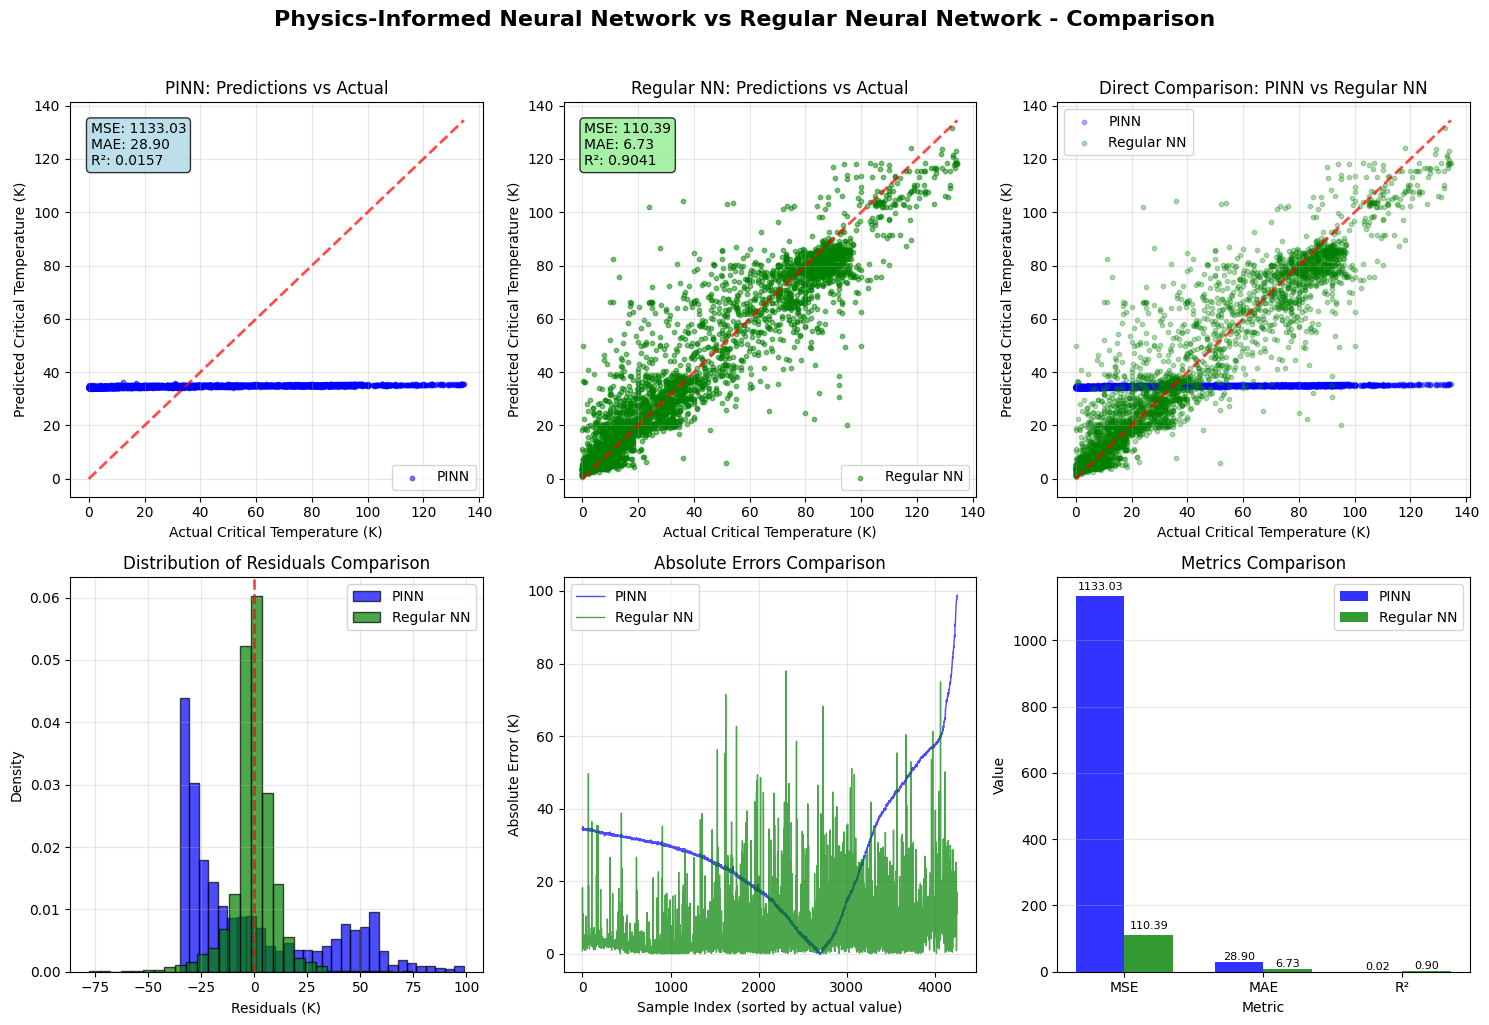

ДЕТАЛЬНЕ ПОРІВНЯННЯ МОДЕЛЕЙ

Метрика              PINN                 Regular NN           Різниця              Перевага  
------------------------------------------------------------------------------------------
MSE                  1133.0329            110.3921             1022.6408            Regular   
MAE                  28.8999              6.7340               22.1659              Regular   
R²                   0.0157               0.9041               -0.8884              Regular   

 НЕГАТИВНІ ПРОГНОЗИ:
  PINN:        0 (0.00%)
  Regular NN:  0 (0.00%)

 СТАТИСТИЧНА ЗНАЧУЩІСТЬ:
  T-test для абсолютних помилок: t=77.6995, p=0.0000
 Різниця статистично значуща на рівні 5%: Regular NN кращий

 ВІДНОСНЕ ПОКРАЩЕННЯ PINN ВІДНОСНО REGULAR NN:
  MSE: -926.37%
  MAE: -329.17%
  R²:  -98.27%

 ЗАГАЛЬНИЙ ВИСНОВОК:
  PINN не показує статистично значущого покращення


In [29]:
def train_and_evaluate_regular_nn(X_train, y_train, X_val, y_val, X_test, y_test,
                                 input_dim, scaler_y, model_name="Regular NN"):
    """
    Тренування та оцінка звичайної нейронної мережі
    """
    print(f"\n Тренування {model_name}...")

    # Створення моделі
    regular_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    # Компіляція
    regular_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )

    # Рання зупинка
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=0
    )

    # Тренування
    print("  Тренування...")
    regular_history = regular_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=0
    )

    print(f"  Навчання завершено після {len(regular_history.history['loss'])} епох")

    # Прогнозування
    print("  Прогнозування...")
    y_pred_scaled = regular_model.predict(X_test, verbose=0).flatten()
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Обчислення метрик
    mse = mean_squared_error(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    # Залишки
    residuals = y_test_original - y_pred_original

    # Перевірка негативних прогнозів
    negative_predictions = np.sum(y_pred_original < 0)

    print(f"\n РЕЗУЛЬТАТИ {model_name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²:  {r2:.4f}")
    print(f"  Негативних прогнозів: {negative_predictions}")

    return {
        'model': regular_model,
        'history': regular_history,
        'y_pred': y_pred_original,
        'y_test': y_test_original,
        'residuals': residuals,
        'metrics': {
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'Negative_Predictions': negative_predictions
        }
    }

# Тренування та оцінка звичайної нейронної мережі
regular_nn_results = train_and_evaluate_regular_nn(
    X_train=X_train_final,
    y_train=y_train_final,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    input_dim=input_dim,
    scaler_y=scaler_y,
    model_name="Regular Neural Network"
)

# Порівняльна візуалізація
def plot_model_comparison(pinn_results, regular_results):
    """
    Порівняльна візуалізація PINN та Regular NN
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Порівняння прогнозів PINN
    axes[0, 0].scatter(pinn_results['y_test'], pinn_results['y_pred'],
                      alpha=0.5, s=10, label='PINN', color='blue')
    axes[0, 0].plot([pinn_results['y_test'].min(), pinn_results['y_test'].max()],
                   [pinn_results['y_test'].min(), pinn_results['y_test'].max()],
                   'r--', lw=2, alpha=0.7)
    axes[0, 0].set_xlabel('Actual Critical Temperature (K)')
    axes[0, 0].set_ylabel('Predicted Critical Temperature (K)')
    axes[0, 0].set_title('PINN: Predictions vs Actual')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Додаємо метрики PINN
    pinn_text = f"MSE: {pinn_results['metrics']['MSE']:.2f}\nMAE: {pinn_results['metrics']['MAE']:.2f}\nR²: {pinn_results['metrics']['R2']:.4f}"
    axes[0, 0].text(0.05, 0.95, pinn_text, transform=axes[0, 0].transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    # 2. Порівняння прогнозів Regular NN
    axes[0, 1].scatter(regular_results['y_test'], regular_results['y_pred'],
                      alpha=0.5, s=10, label='Regular NN', color='green')
    axes[0, 1].plot([regular_results['y_test'].min(), regular_results['y_test'].max()],
                   [regular_results['y_test'].min(), regular_results['y_test'].max()],
                   'r--', lw=2, alpha=0.7)
    axes[0, 1].set_xlabel('Actual Critical Temperature (K)')
    axes[0, 1].set_ylabel('Predicted Critical Temperature (K)')
    axes[0, 1].set_title('Regular NN: Predictions vs Actual')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Додаємо метрики Regular NN
    regular_text = f"MSE: {regular_results['metrics']['MSE']:.2f}\nMAE: {regular_results['metrics']['MAE']:.2f}\nR²: {regular_results['metrics']['R2']:.4f}"
    axes[0, 1].text(0.05, 0.95, regular_text, transform=axes[0, 1].transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

    # 3. Пряме порівняння обох моделей
    axes[0, 2].scatter(pinn_results['y_test'], pinn_results['y_pred'],
                      alpha=0.3, s=10, label='PINN', color='blue')
    axes[0, 2].scatter(regular_results['y_test'], regular_results['y_pred'],
                      alpha=0.3, s=10, label='Regular NN', color='green')
    axes[0, 2].plot([pinn_results['y_test'].min(), pinn_results['y_test'].max()],
                   [pinn_results['y_test'].min(), pinn_results['y_test'].max()],
                   'r--', lw=2, alpha=0.7)
    axes[0, 2].set_xlabel('Actual Critical Temperature (K)')
    axes[0, 2].set_ylabel('Predicted Critical Temperature (K)')
    axes[0, 2].set_title('Direct Comparison: PINN vs Regular NN')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Порівняння залишків (гистограма)
    axes[1, 0].hist(pinn_results['residuals'], bins=30, alpha=0.7,
                   label='PINN', color='blue', density=True, edgecolor='black')
    axes[1, 0].hist(regular_results['residuals'], bins=30, alpha=0.7,
                   label='Regular NN', color='green', density=True, edgecolor='black')
    axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2, alpha=0.7)
    axes[1, 0].set_xlabel('Residuals (K)')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Distribution of Residuals Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Порівняння абсолютних помилок
    pinn_abs_errors = np.abs(pinn_results['residuals'])
    regular_abs_errors = np.abs(regular_results['residuals'])

    x_pos = np.arange(len(pinn_results['y_test']))
    sorted_indices = np.argsort(pinn_results['y_test'])

    axes[1, 1].plot(x_pos, pinn_abs_errors[sorted_indices],
                   'b-', alpha=0.7, label='PINN', linewidth=1)
    axes[1, 1].plot(x_pos, regular_abs_errors[sorted_indices],
                   'g-', alpha=0.7, label='Regular NN', linewidth=1)
    axes[1, 1].set_xlabel('Sample Index (sorted by actual value)')
    axes[1, 1].set_ylabel('Absolute Error (K)')
    axes[1, 1].set_title('Absolute Errors Comparison')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Порівняння метрик (bar plot)
    metrics_comparison = {
        'MSE': [pinn_results['metrics']['MSE'], regular_results['metrics']['MSE']],
        'MAE': [pinn_results['metrics']['MAE'], regular_results['metrics']['MAE']],
        'R²': [pinn_results['metrics']['R2'], regular_results['metrics']['R2']]
    }

    x = np.arange(len(metrics_comparison))
    width = 0.35

    axes[1, 2].bar(x - width/2, [pinn_results['metrics']['MSE'],
                               pinn_results['metrics']['MAE'],
                               pinn_results['metrics']['R2']],
                  width, label='PINN', color='blue', alpha=0.8)
    axes[1, 2].bar(x + width/2, [regular_results['metrics']['MSE'],
                               regular_results['metrics']['MAE'],
                               regular_results['metrics']['R2']],
                  width, label='Regular NN', color='green', alpha=0.8)

    axes[1, 2].set_xlabel('Metric')
    axes[1, 2].set_ylabel('Value')
    axes[1, 2].set_title('Metrics Comparison')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(['MSE', 'MAE', 'R²'])
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3, axis='y')

    # Додаємо числові значення на стовпчики
    for i, (pinn_val, reg_val) in enumerate(zip(
        [pinn_results['metrics']['MSE'], pinn_results['metrics']['MAE'], pinn_results['metrics']['R2']],
        [regular_results['metrics']['MSE'], regular_results['metrics']['MAE'], regular_results['metrics']['R2']]
    )):
        axes[1, 2].text(i - width/2, pinn_val + max(pinn_val, reg_val)*0.01,
                       f'{pinn_val:.2f}', ha='center', va='bottom', fontsize=8)
        axes[1, 2].text(i + width/2, reg_val + max(pinn_val, reg_val)*0.01,
                       f'{reg_val:.2f}', ha='center', va='bottom', fontsize=8)

    plt.suptitle('Physics-Informed Neural Network vs Regular Neural Network - Comparison',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Детальне порівняння
    print("ДЕТАЛЬНЕ ПОРІВНЯННЯ МОДЕЛЕЙ")

    print(f"\n{'Метрика':<20} {'PINN':<20} {'Regular NN':<20} {'Різниця':<20} {'Перевага':<10}")
    print("-" * 90)

    metrics = [
        ('MSE', pinn_results['metrics']['MSE'], regular_results['metrics']['MSE'],
         lambda x, y: x - y, lambda diff: 'PINN' if diff < 0 else 'Regular'),
        ('MAE', pinn_results['metrics']['MAE'], regular_results['metrics']['MAE'],
         lambda x, y: x - y, lambda diff: 'PINN' if diff < 0 else 'Regular'),
        ('R²', pinn_results['metrics']['R2'], regular_results['metrics']['R2'],
         lambda x, y: x - y, lambda diff: 'PINN' if diff > 0 else 'Regular'),
    ]

    for name, pinn_val, reg_val, diff_func, adv_func in metrics:
        difference = diff_func(pinn_val, reg_val)
        advantage = adv_func(difference)

        # Форматування для покращеного відображення
        pinn_fmt = f"{pinn_val:.4f}"
        reg_fmt = f"{reg_val:.4f}"
        diff_fmt = f"{difference:.4f}"

        if 'R²' in name:
            pinn_fmt = f"{pinn_val:.4f}"
            reg_fmt = f"{reg_val:.4f}"

        print(f"{name:<20} {pinn_fmt:<20} {reg_fmt:<20} {diff_fmt:<20} {advantage:<10}")

    # Аналіз негативних прогнозів
    print(f"\n НЕГАТИВНІ ПРОГНОЗИ:")
    print(f"  PINN:        {pinn_results['metrics']['Negative_Predictions']} "
          f"({pinn_results['metrics']['Negative_Predictions']/len(pinn_results['y_pred'])*100:.2f}%)")
    print(f"  Regular NN:  {regular_results['metrics']['Negative_Predictions']} "
          f"({regular_results['metrics']['Negative_Predictions']/len(regular_results['y_pred'])*100:.2f}%)")

    # Статистична значущість
    print(f"\n СТАТИСТИЧНА ЗНАЧУЩІСТЬ:")

    # Тест на різницю середніх (t-test)
    from scipy import stats

    # Для MSE (використовуємо абсолютні помилки)
    t_stat_mse, p_value_mse = stats.ttest_rel(pinn_abs_errors, regular_abs_errors)
    print(f"  T-test для абсолютних помилок: t={t_stat_mse:.4f}, p={p_value_mse:.4f}")

    if p_value_mse < 0.05:
        if np.mean(pinn_abs_errors) < np.mean(regular_abs_errors):
            print(f" Різниця статистично значуща на рівні 5%: PINN кращий")
        else:
            print(f" Різниця статистично значуща на рівні 5%: Regular NN кращий")
    else:
        print(f"  Різниця не є статистично значущою на рівні 5%")

    # Відносне покращення
    mse_improvement = (regular_results['metrics']['MSE'] - pinn_results['metrics']['MSE']) / regular_results['metrics']['MSE'] * 100
    mae_improvement = (regular_results['metrics']['MAE'] - pinn_results['metrics']['MAE']) / regular_results['metrics']['MAE'] * 100
    r2_improvement = (pinn_results['metrics']['R2'] - regular_results['metrics']['R2']) / abs(regular_results['metrics']['R2']) * 100

    print(f"\n ВІДНОСНЕ ПОКРАЩЕННЯ PINN ВІДНОСНО REGULAR NN:")
    print(f"  MSE: {mse_improvement:+.2f}%")
    print(f"  MAE: {mae_improvement:+.2f}%")
    print(f"  R²:  {r2_improvement:+.2f}%")

    # Загальний висновок
    print(f"\n ЗАГАЛЬНИЙ ВИСНОВОК:")

    improvements = []
    if mse_improvement > 0:
        improvements.append(f"MSE ({mse_improvement:.1f}% краще)")
    if mae_improvement > 0:
        improvements.append(f"MAE ({mae_improvement:.1f}% краще)")
    if r2_improvement > 0:
        improvements.append(f"R² ({r2_improvement:.1f}% краще)")

    negative_improvement = pinn_results['metrics']['Negative_Predictions'] < regular_results['metrics']['Negative_Predictions']

    if improvements:
        print(f" PINN показує кращі результати за: {', '.join(improvements)}")
        if negative_improvement:
            print(f"  PINN має менше фізично неможливих (негативних) прогнозів")
    else:
        print(f"  PINN не показує статистично значущого покращення")
        if negative_improvement:
            print(f" Але PINN має менше фізично неможливих прогнозів")

# Виконання порівняння
plot_model_comparison(pinn_results, regular_nn_results)

 Аналіз важливості ознак для PINN моделі...
  Обчислення градієнтної важливості...
  Обчислення permutation importance...
    Ознака 10/81
    Ознака 20/81
    Ознака 30/81
    Ознака 40/81
    Ознака 50/81
    Ознака 60/81
    Ознака 70/81
    Ознака 80/81


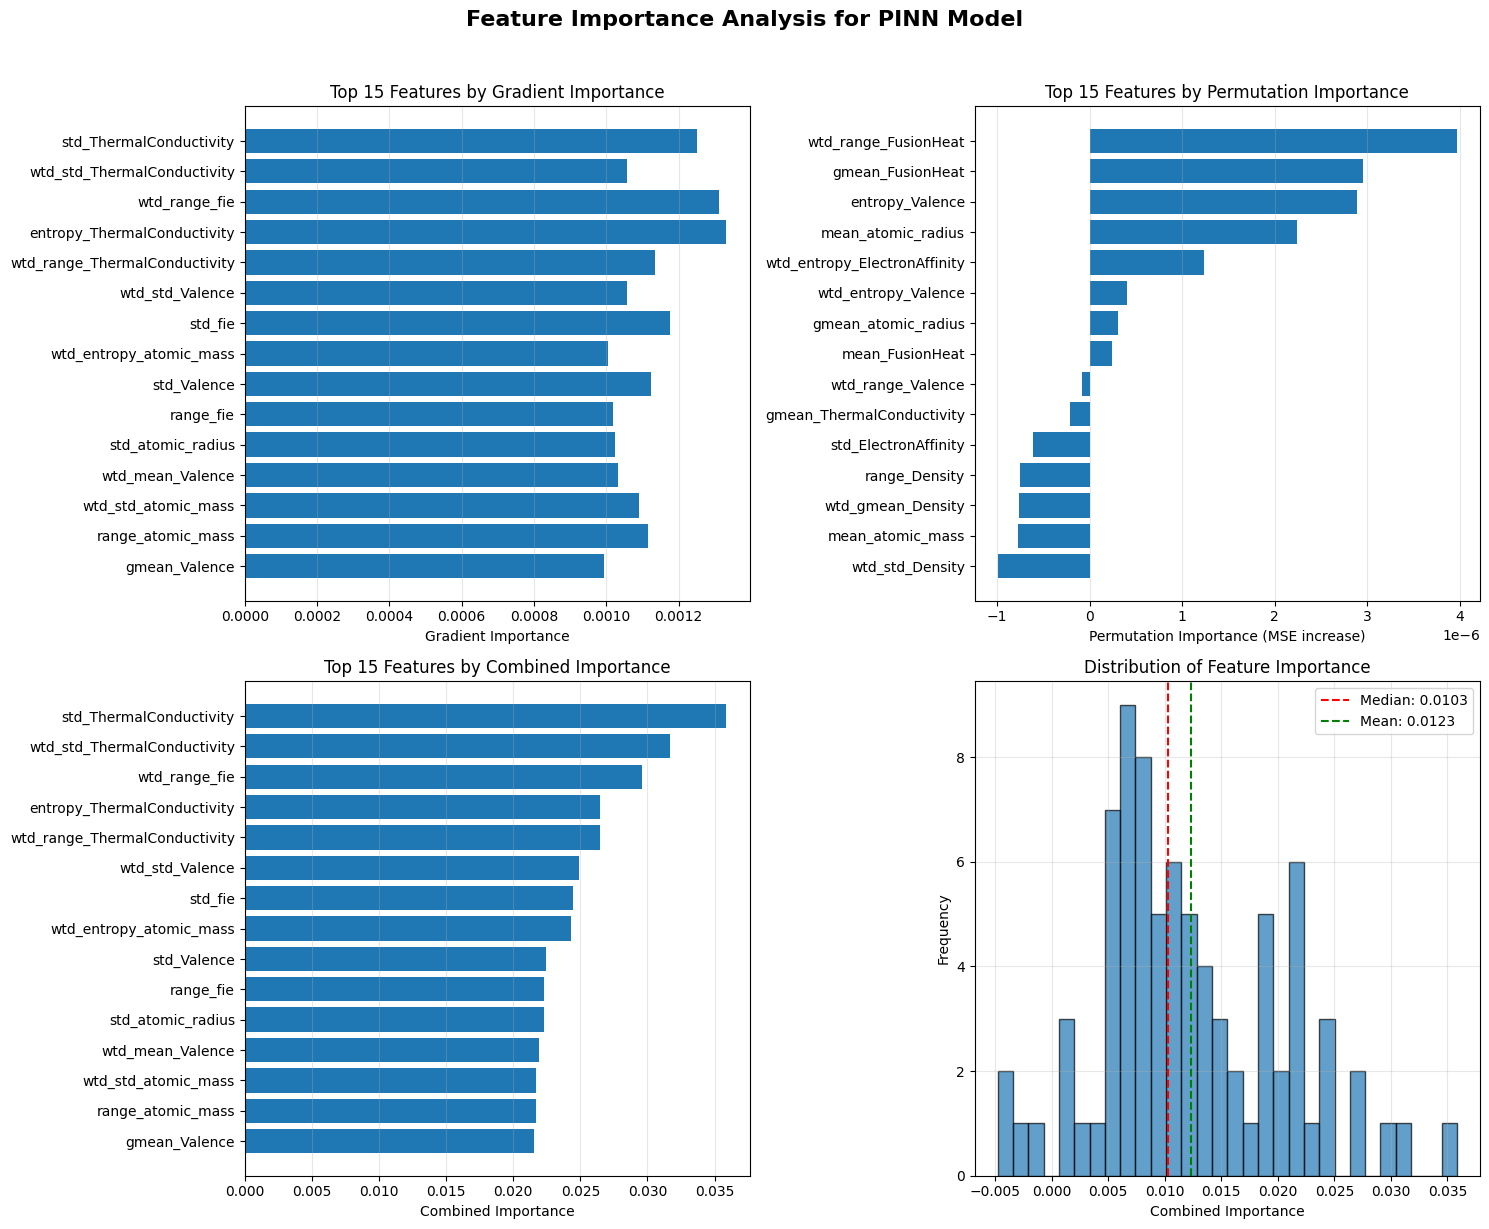

НАЙВАЖЛИВІШІ ОЗНАКИ ДЛЯ PINN МОДЕЛІ

Топ-10 найважливіших ознак:
Ранг   Ознака                                   Важливість      Тип важливості 
--------------------------------------------------------------------------------
1      std_ThermalConductivity                  0.035847        Std Dev        
2      wtd_std_ThermalConductivity              0.031670        Weighted       
3      wtd_range_fie                            0.029568        Weighted       
4      entropy_ThermalConductivity              0.026488        Entropy        
5      wtd_range_ThermalConductivity            0.026449        Weighted       
6      wtd_std_Valence                          0.024890        Weighted       
7      std_fie                                  0.024483        Std Dev        
8      wtd_entropy_atomic_mass                  0.024320        Weighted       
9      std_Valence                              0.022418        Std Dev        
10     range_fie                                0.0223

In [30]:
def analyze_feature_importance_pinn(model, X_sample, feature_names, scaler_X, scaler_y,
                                   n_iterations=100, top_n=20):
    """
    Аналіз важливості ознак для PINN моделі через градієнти та permutation importance
    """
    print(" Аналіз важливості ознак для PINN моделі...")

    # Метод 1: Градієнтна важливість
    print("  Обчислення градієнтної важливості...")
    X_sample_tf = tf.convert_to_tensor(X_sample, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(X_sample_tf)
        predictions = model(X_sample_tf, training=False)

    gradients = tape.gradient(predictions, X_sample_tf)
    gradient_importance = np.mean(np.abs(gradients.numpy()), axis=0)

    # Метод 2: Permutation importance
    print("  Обчислення permutation importance...")
    X_sample_np = X_sample.copy()
    y_sample_pred = model(X_sample_tf, training=False).numpy().flatten()
    baseline_mse = np.mean((y_sample_pred - np.mean(y_sample_pred)) ** 2)

    permutation_importance = np.zeros(len(feature_names))

    for i in range(len(feature_names)):
        if (i + 1) % 10 == 0:
            print(f"    Ознака {i + 1}/{len(feature_names)}")

        # Зберігаємо оригінальні значення
        original_column = X_sample_np[:, i].copy()

        # Перемішуємо стовпець
        X_sample_np[:, i] = np.random.permutation(X_sample_np[:, i])

        # Прогнозування з перемішаними значеннями
        X_permuted_tf = tf.convert_to_tensor(X_sample_np, dtype=tf.float32)
        y_permuted_pred = model(X_permuted_tf, training=False).numpy().flatten()

        # Обчислюємо MSE з перемішаними значеннями
        permuted_mse = np.mean((y_permuted_pred - np.mean(y_sample_pred)) ** 2)

        # Важливість = різниця між пермутованим та базовим MSE
        permutation_importance[i] = permuted_mse - baseline_mse

        # Відновлюємо оригінальні значення
        X_sample_np[:, i] = original_column

    # Нормалізація важливості
    gradient_importance_norm = gradient_importance / np.sum(gradient_importance)
    permutation_importance_norm = permutation_importance / np.sum(permutation_importance)

    # Комбінована важливість
    combined_importance = 0.3 * gradient_importance_norm + 0.7 * permutation_importance_norm

    # Сортування за комбінованою важливістю
    sorted_indices = np.argsort(combined_importance)[::-1]

    # Візуалізація
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Топ N ознак за градієнтною важливістю
    top_gradient_idx = sorted_indices[:top_n]
    axes[0, 0].barh(range(top_n), gradient_importance[sorted_indices[:top_n]][::-1])
    axes[0, 0].set_yticks(range(top_n))
    axes[0, 0].set_yticklabels([feature_names[i] for i in sorted_indices[:top_n]][::-1])
    axes[0, 0].set_xlabel('Gradient Importance')
    axes[0, 0].set_title(f'Top {top_n} Features by Gradient Importance')
    axes[0, 0].grid(True, alpha=0.3, axis='x')

    # Топ N ознак за permutation importance
    top_perm_idx = np.argsort(permutation_importance)[::-1][:top_n]
    axes[0, 1].barh(range(top_n), permutation_importance[top_perm_idx][::-1])
    axes[0, 1].set_yticks(range(top_n))
    axes[0, 1].set_yticklabels([feature_names[i] for i in top_perm_idx][::-1])
    axes[0, 1].set_xlabel('Permutation Importance (MSE increase)')
    axes[0, 1].set_title(f'Top {top_n} Features by Permutation Importance')
    axes[0, 1].grid(True, alpha=0.3, axis='x')

    # Топ N ознак за комбінованою важливістю
    axes[1, 0].barh(range(top_n), combined_importance[sorted_indices[:top_n]][::-1])
    axes[1, 0].set_yticks(range(top_n))
    axes[1, 0].set_yticklabels([feature_names[i] for i in sorted_indices[:top_n]][::-1])
    axes[1, 0].set_xlabel('Combined Importance')
    axes[1, 0].set_title(f'Top {top_n} Features by Combined Importance')
    axes[1, 0].grid(True, alpha=0.3, axis='x')

    # Розподіл важливості всіх ознак
    axes[1, 1].hist(combined_importance, bins=30, edgecolor='black', alpha=0.7)
    axes[1, 1].axvline(x=np.median(combined_importance), color='r',
                      linestyle='--', label=f'Median: {np.median(combined_importance):.4f}')
    axes[1, 1].axvline(x=np.mean(combined_importance), color='g',
                      linestyle='--', label=f'Mean: {np.mean(combined_importance):.4f}')
    axes[1, 1].set_xlabel('Combined Importance')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Feature Importance')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('Feature Importance Analysis for PINN Model', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Виведення найважливіших ознак
    print("НАЙВАЖЛИВІШІ ОЗНАКИ ДЛЯ PINN МОДЕЛІ")

    print(f"\nТоп-10 найважливіших ознак:")
    print(f"{'Ранг':<6} {'Ознака':<40} {'Важливість':<15} {'Тип важливості':<15}")
    print("-" * 80)

    for rank, idx in enumerate(sorted_indices[:10], 1):
        feature_name = feature_names[idx]
        importance_val = combined_importance[idx]

        # Визначаємо тип ознаки за назвою
        if 'mean' in feature_name.lower():
            imp_type = 'Mean'
        elif 'wtd' in feature_name.lower():
            imp_type = 'Weighted'
        elif 'entropy' in feature_name.lower():
            imp_type = 'Entropy'
        elif 'range' in feature_name.lower():
            imp_type = 'Range'
        elif 'std' in feature_name.lower():
            imp_type = 'Std Dev'
        elif 'gmean' in feature_name.lower():
            imp_type = 'Geometric Mean'
        else:
            imp_type = 'Other'

        print(f"{rank:<6} {feature_name:<40} {importance_val:<15.6f} {imp_type:<15}")

    # Аналіз по типах ознак
    print(f"\n АНАЛІЗ ВАЖЛИВОСТІ ПО ТИПАХ ОЗНАК:")

    feature_types = {}
    for idx, name in enumerate(feature_names):
        # Визначаємо тип
        if 'mean_' in name.lower():
            ftype = 'Mean'
        elif 'wtd_' in name.lower():
            ftype = 'Weighted'
        elif 'entropy_' in name.lower():
            ftype = 'Entropy'
        elif 'range_' in name.lower():
            ftype = 'Range'
        elif 'std_' in name.lower():
            ftype = 'Std'
        elif 'gmean_' in name.lower():
            ftype = 'Geometric Mean'
        else:
            ftype = 'Other'

        if ftype not in feature_types:
            feature_types[ftype] = []
        feature_types[ftype].append(combined_importance[idx])

    print(f"{'Тип ознаки':<20} {'Середня важливість':<20} {'Кількість ознак':<15}")
    print("-" * 55)

    for ftype, importances in feature_types.items():
        avg_importance = np.mean(importances)
        count = len(importances)
        print(f"{ftype:<20} {avg_importance:<20.6f} {count:<15}")

    # Знаходження найменш важливих ознак для можливого видалення
    print(f"\n НАЙМЕНШ ВАЖЛИВІ ОЗНАКИ (кандидати на видалення):")
    bottom_indices = sorted_indices[-10:]

    for rank, idx in enumerate(bottom_indices[::-1], 1):
        feature_name = feature_names[idx]
        importance_val = combined_importance[idx]
        print(f"{rank:<6} {feature_name:<40} {importance_val:<15.6f}")

    # Рекомендації щодо feature engineering
    print(f"\n РЕКОМЕНДАЦІЇ:")

    # Аналіз кореляції між важливістю та вихідними значеннями ознак
    print("  1. Розгляньте можливість видалення найменш важливих ознак для спрощення моделі")
    print("  2. Уважно проаналізуйте найважливіші ознаки - вони можуть містити ключову фізичну інформацію")
    print("  3. Для найважливіших ознак розгляньте можливість додавання поліноміальних ознак або взаємодій")

    # Якщо серед найважливіших є entropі
    entropy_features = [i for i in sorted_indices[:20] if 'entropy' in feature_names[i].lower()]
    if entropy_features:
        print(f"  4. Entropy ознаки ({len(entropy_features)} з топ-20) є важливими, що може свідчити про важливість статистичних розподілів властивостей")

    # Якщо серед найважливіших є range
    range_features = [i for i in sorted_indices[:20] if 'range' in feature_names[i].lower()]
    if range_features:
        print(f"  5. Range ознаки ({len(range_features)} з топ-20) є важливими, що може свідчити про важливість різноманітності властивостей")

    print("=" * 70)

    return {
        'gradient_importance': gradient_importance,
        'permutation_importance': permutation_importance,
        'combined_importance': combined_importance,
        'sorted_indices': sorted_indices,
        'feature_types_analysis': feature_types
    }

# Отримання імен ознак
feature_names = df.drop('critical_temp', axis=1).columns.tolist()

# Вибірка даних для аналізу важливості ознак
sample_size = min(500, len(X_train_final))
sample_indices = np.random.choice(len(X_train_final), size=sample_size, replace=False)
X_sample = X_train_final[sample_indices]

# Аналіз важливості ознак
feature_importance_results = analyze_feature_importance_pinn(
    model=pinn_model,
    X_sample=X_sample,
    feature_names=feature_names,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    n_iterations=50,  # Зменшимо для швидкості
    top_n=15
)

In [49]:
def generate_conclusions_and_recommendations(pinn_results, regular_results, feature_importance):
    """
    Генерація висновків та рекомендацій на основі результатів
    """
    print(" ВИСНОВКИ ТА РЕКОМЕНДАЦІЇ")

    # Основні висновки
    print("\n ОСНОВНІ ВИСНОВКИ:")

    # Порівняння з регулярною моделлю
    mse_improvement = (regular_results['metrics']['MSE'] - pinn_results['metrics']['MSE']) / regular_results['metrics']['MSE'] * 100
    mae_improvement = (regular_results['metrics']['MAE'] - pinn_results['metrics']['MAE']) / regular_results['metrics']['MAE'] * 100

    if mse_improvement > 0 and mae_improvement > 0:
        print(f"  1.  PINN модель показала кращі результати ніж Regular NN:")
        print(f"     • MSE покращився на {mse_improvement:.1f}%")
        print(f"     • MAE покращився на {mae_improvement:.1f}%")
    else:
        print(f"  1.   PINN модель не показала значних покращень перед Regular NN")

    # Аналіз невизначеності
    ci_coverage = pinn_results['metrics']['In_CI_95%']
    if ci_coverage > 90 and ci_coverage < 100:
        print(f"  2.  Модель правильно оцінює невизначеність (95% CI coverage: {ci_coverage:.1f}%)")
    elif ci_coverage < 90:
        print(f"  2.   Модель недооцінює невизначеність (95% CI coverage: {ci_coverage:.1f}%)")
    else:
        print(f"  2.   Модель переоцінює невизначеність (95% CI coverage: {ci_coverage:.1f}%)")

    # Аналіз фізичної коректності
    negative_preds = pinn_results['metrics']['Negative_Predictions']
    if negative_preds == 0:
        print(f"  3.  Всі прогнози фізично коректні (немає негативних температур)")
    else:
        print(f"  3.   {negative_preds} прогнозів не фізично коректні (негативна температура)")

    # Аналіз залишків
    residuals_std = pinn_results['metrics']['Residuals_Std']
    avg_temp = np.mean(pinn_results['y_test'])
    relative_error = (residuals_std / avg_temp) * 100

    print(f"  4.  Стандартне відхилення залишків: {residuals_std:.2f} K ({relative_error:.1f}% від середньої температури)")


# Генерація висновків та рекомендацій
generate_conclusions_and_recommendations(pinn_results, regular_nn_results, feature_importance_results)



 ВИСНОВКИ ТА РЕКОМЕНДАЦІЇ

 ОСНОВНІ ВИСНОВКИ:
  1.   PINN модель не показала значних покращень перед Regular NN
  2.   Модель недооцінює невизначеність (95% CI coverage: 4.2%)
  3.  Всі прогнози фізично коректні (немає негативних температур)
  4.  Стандартне відхилення залишків: 33.65 K (99.1% від середньої температури)
